In [ ]:
def distribution1(x, batch_size=512):
    # Distribution defined as (x, U(0,1)). Can be used for question 3
    while True:
        yield(np.array([(x, random.uniform(0, 1)) for _ in range(batch_size)]))


def distribution2(batch_size=512):
    # High dimension uniform distribution
    while True:
        yield(np.random.uniform(0, 1, (batch_size, 2)))


def distribution3(batch_size=512):
    # 1D gaussian distribution
    while True:
        yield(np.random.normal(0, 1, (batch_size, 1)))

e = lambda x: np.exp(x)
tanh = lambda x: (e(x) - e(-x)) / (e(x)+e(-x))
def distribution4(batch_size=1):
    # arbitrary sampler
    f = lambda x: tanh(x*2+1) + x*0.75
    while True:
        yield(f(np.random.normal(0, 1, (batch_size, 1))))

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib as mpl
import matplotlib.pyplot as plt
import random
import math
from torch.autograd import Variable,grad

In [ ]:
cuda = True if torch.cuda.is_available() else False
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
#To initialize weights of network
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.0)

###Problem 1.1

In [ ]:
#Discriminator for Q1.1
class Discriminator(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super(Discriminator, self).__init__()
    self.fc1 = nn.Linear(input_size, hidden_size)
    self.fc2 = nn.Linear(hidden_size, hidden_size)
    self.fc3 = nn.Linear(hidden_size, output_size)
  
  def forward(self,x):
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    return torch.sigmoid_(self.fc3(x))

In [ ]:
#Q1.1 : Loss function to estimate JS Divergence
def js_loss(D, dist1, dist2):
  dist1_loss = torch.mean(torch.log(D(dist1)))
  dist2_loss = torch.mean(torch.log(1-D(dist2)))
  return -(dist1_loss+dist2_loss)

In [ ]:
#Q1.1 : Train function to estimate JS Divergence using js_loss
def train_js(_phi = 0):
  # Model parameters
  d_input_size = 2    
  d_hidden_size = 10
  d_output_size = 1     
  minibatch_size = 512
  d_learning_rate = 1e-3
  sgd_momentum = 0.9
  num_epochs = 3000
  print_interval = 500
  dist1_sample, dist2_sample= None, None

  D = Discriminator(input_size=d_input_size,
                      hidden_size=d_hidden_size,
                      output_size=d_output_size)
  
  if cuda:
    D.cuda()
    
  D.apply(init_weights) #Initialize discriminator weights
  d_optimizer = optim.SGD(D.parameters(), lr=d_learning_rate, momentum=sgd_momentum) #Optimizer SGD with momentum
  
  dist1 = iter(distribution1(0, 512)) #Distribution1= (0, Z) iterator where Z~Uniform(0,1)
  dist2 = iter(distribution1(_phi, 512)) #Distribution2 = (_phi, Z)iterator where Z~Uniform(0,1)

  for epoch in range(num_epochs):
    # Initialize grads
    D.zero_grad()
    
    #Generate dist1 data
    dist1_sample = next(dist1)
    if cuda:
      dist1_sample = torch.from_numpy(dist1_sample).float().cuda()
      dist1_sample = Variable(dist1_sample)
      #print(dist1_sample.shape)

    #Generate dist2 data
    dist2_sample = next(dist2)
    if cuda:
      dist2_sample = torch.from_numpy(dist2_sample).float().cuda()
      dist2_sample = Variable(dist2_sample)
      #print(dist2_sample.shape)

    #Calculate loss
    loss = js_loss(D, dist1_sample, dist2_sample)
    loss.backward()

    d_optimizer.step() #  optimizes D's parameters; changes based on stored gradients from backward()
    

    if epoch % print_interval == 0:
      print("Epoch %s: D ( JS Loss %s ) " %(epoch, loss))
      
    #print("Epoch %s: D JS Loss %s  " %(epoch, loss))
   
  #Return final loss
  return loss

###Problem 1.2

In [ ]:
#Q1.2 Critic Network
class Critic(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super(Critic, self).__init__()
    self.fc1 = nn.Linear(input_size, hidden_size)
    self.fc2 = nn.Linear(hidden_size, hidden_size)
    self.fc3 = nn.Linear(hidden_size, output_size)
  
  def forward(self,x):
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    return self.fc3(x)

In [ ]:
#Q1.2 Loss function to estimate Wasserstein Distance
def wd_loss(critic, dist1_samples, dist2_samples, lamda =10):
  dist1_loss = torch.mean(critic(dist1_samples))
  dist2_loss = torch.mean(critic(dist2_samples))
  a = torch.FloatTensor(512, 1).uniform_(0, 1)
  a = a.float().cuda()
  z = a * dist1_samples + (1-a)*dist2_samples
  z = Variable(z, requires_grad = True)
  T_z  = critic(z)
  grad_penalty = grad( T_z , z, grad_outputs=torch.ones(T_z.size()).cuda(),create_graph=True, only_inputs=True, retain_graph=True)[0]
  grad_penalty = grad_penalty.view(512, -1)
  grad_penalty = (grad_penalty.norm(2, dim=1) -1)**2
  wd_loss = -(dist1_loss - dist2_loss -  lamda * grad_penalty.mean())
  return wd_loss

In [ ]:
#Q1.2 : Train function to estimate Wasserstein Distance using wd_loss
def train_wd(_phi = 0):
  # Model parameters
  d_input_size = 2    
  d_hidden_size = 10   
  d_output_size = 1     
  minibatch_size = 512
  d_learning_rate = 1e-3
  sgd_momentum = 0.9
  num_epochs = 3000
  print_interval = 500
  dist1_sample, dist2_sample= None, None

  T = Critic(input_size=d_input_size, 
             hidden_size=d_hidden_size, 
             output_size=d_output_size)
  if cuda:
    T.cuda()
    
  T.apply(init_weights) #Initialize critic
  
  d_optimizer = optim.SGD(T.parameters(), lr=d_learning_rate, momentum=sgd_momentum)
  
  dist1 = iter(distribution1(0, 512)) #Distribution1= (0, Z) iterator where Z~Uniform(0,1)
  dist2 = iter(distribution1(_phi, 512)) #Distribution2 = (_phi, Z)iterator where Z~Uniform(0,1)
  
  for epoch in range(num_epochs):
    # Initialize grads
    T.zero_grad()
    
    #Generate dist1 data
    dist1_sample = next(dist1)
    if cuda:
      dist1_sample = torch.from_numpy(dist1_sample).float().cuda()
      dist1_sample = Variable(dist1_sample)
      #print(dist1_sample.shape)

    #Generate dist2 data
    dist2_sample = next(dist2)
    if cuda:
      dist2_sample = torch.from_numpy(dist2_sample).float().cuda()
      dist2_sample = Variable(dist2_sample)
      #print(dist2_sample.shape)

    #Calculate loss
    loss = wd_loss(T, dist1_sample, dist2_sample)
    loss.backward()
    
    d_optimizer.step() #  optimizes D's parameters; changes based on stored gradients from backward()

    if epoch % print_interval == 0:
      print("Epoch %s: D (%s WD Loss) " %(epoch, loss))
  
  #Return final loss
  return loss

###Problem 1.3

In [ ]:
#Q1.3
jsd_loss_list = []
for i in np.linspace(-1,1,21):
  _phi = i
  print('_phi = %s' %_phi)
  train_loss = train_js(_phi)
  jsd_loss =  np.log(2) - train_loss.item()/2.0 
  jsd_loss_list.append(jsd_loss)

_phi = -1.0
Epoch 0: D ( JS Loss tensor(1.3766, device='cuda:0', grad_fn=<NegBackward>) ) 
Epoch 500: D ( JS Loss tensor(0.2391, device='cuda:0', grad_fn=<NegBackward>) ) 
Epoch 1000: D ( JS Loss tensor(0.0457, device='cuda:0', grad_fn=<NegBackward>) ) 
Epoch 1500: D ( JS Loss tensor(0.0187, device='cuda:0', grad_fn=<NegBackward>) ) 
Epoch 2000: D ( JS Loss tensor(0.0109, device='cuda:0', grad_fn=<NegBackward>) ) 
Epoch 2500: D ( JS Loss tensor(0.0072, device='cuda:0', grad_fn=<NegBackward>) ) 
_phi = -0.9
Epoch 0: D ( JS Loss tensor(1.4716, device='cuda:0', grad_fn=<NegBackward>) ) 
Epoch 500: D ( JS Loss tensor(0.9222, device='cuda:0', grad_fn=<NegBackward>) ) 
Epoch 1000: D ( JS Loss tensor(0.0651, device='cuda:0', grad_fn=<NegBackward>) ) 
Epoch 1500: D ( JS Loss tensor(0.0186, device='cuda:0', grad_fn=<NegBackward>) ) 
Epoch 2000: D ( JS Loss tensor(0.0098, device='cuda:0', grad_fn=<NegBackward>) ) 
Epoch 2500: D ( JS Loss tensor(0.0062, device='cuda:0', grad_fn=<NegBackward>) ) 


In [ ]:
#Q1.3
wd_loss_list = []
for i in np.linspace(-1,1,21):
  _phi = i
  print('_phi = %s' %_phi)
  train_loss = train_wd(_phi)
  wd_loss_ =  - train_loss.item() 
  wd_loss_list.append(wd_loss_)

_phi = -1.0
Epoch 0: D (tensor(4.0349, device='cuda:0', grad_fn=<NegBackward>) WD Loss) 
Epoch 500: D (tensor(-1.0229, device='cuda:0', grad_fn=<NegBackward>) WD Loss) 
Epoch 1000: D (tensor(-1.0240, device='cuda:0', grad_fn=<NegBackward>) WD Loss) 
Epoch 1500: D (tensor(-1.0246, device='cuda:0', grad_fn=<NegBackward>) WD Loss) 
Epoch 2000: D (tensor(-1.0248, device='cuda:0', grad_fn=<NegBackward>) WD Loss) 
Epoch 2500: D (tensor(-1.0248, device='cuda:0', grad_fn=<NegBackward>) WD Loss) 
_phi = -0.9
Epoch 0: D (tensor(3.6358, device='cuda:0', grad_fn=<NegBackward>) WD Loss) 
Epoch 500: D (tensor(-0.9185, device='cuda:0', grad_fn=<NegBackward>) WD Loss) 
Epoch 1000: D (tensor(-0.9187, device='cuda:0', grad_fn=<NegBackward>) WD Loss) 
Epoch 1500: D (tensor(-0.9197, device='cuda:0', grad_fn=<NegBackward>) WD Loss) 
Epoch 2000: D (tensor(-0.9199, device='cuda:0', grad_fn=<NegBackward>) WD Loss) 
Epoch 2500: D (tensor(-0.9198, device='cuda:0', grad_fn=<NegBackward>) WD Loss) 
_phi = -0.8
Ep

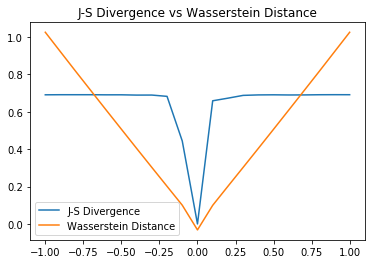

In [ ]:
#Q1.3 Plot JS Divergence vs Wasserstein Distance
x = np.linspace(-1,1,21)
plt.plot(x, jsd_loss_list)
plt.plot(x, wd_loss_list)
plt.legend(['J-S Divergence','Wasserstein Distance'])
plt.title('J-S Divergence vs Wasserstein Distance')
plt.show()

### Problem 1.4

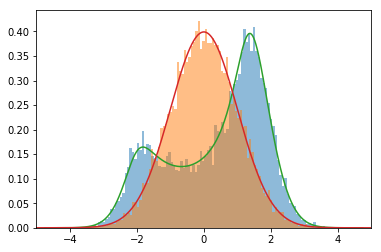

In [ ]:
from __future__ import print_function
import numpy as np
import torch 
import matplotlib.pyplot as plt

# plot p0 and p1
plt.figure()

# empirical
xx = torch.randn(10000)
f = lambda x: torch.tanh(x*2+1) + x*0.75
d = lambda x: (1-torch.tanh(x*2+1)**2)*2+0.75
plt.hist(f(xx), 100, alpha=0.5, density=1)
plt.hist(xx, 100, alpha=0.5, density=1)
plt.xlim(-5,5)
# exact
xx = np.linspace(-5,5,1000)
N = lambda x: np.exp(-x**2/2.)/((2*np.pi)**0.5)
plt.plot(f(torch.from_numpy(xx)).numpy(), d(torch.from_numpy(xx)).numpy()**(-1)*N(xx))
plt.plot(xx, N(xx))


In [ ]:
############### import the sampler ``samplers.distribution4'' 
############### train a discriminator on distribution4 and standard gaussian
############### estimate the density of distribution4

#######--- INSERT YOUR CODE BELOW ---#######

#Discriminator
class Discriminator_1(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super(Discriminator_1, self).__init__()
    self.fc1 = nn.Linear(input_size, hidden_size)
    self.fc2 = nn.Linear(hidden_size, hidden_size)
    self.fc3 = nn.Linear(hidden_size, output_size)
  
  def forward(self,x):
    x = F.leaky_relu_(self.fc1(x), negative_slope=0.1)
    x = F.leaky_relu_(self.fc2(x), negative_slope=0.1)
    return  torch.sigmoid(self.fc3(x))
  #def forward(self,x):
  #  x = torch.sigmoid(self.fc1(x))
  #  x = torch.sigmoid(self.fc2(x))
  #  return  torch.sigmoid(self.fc3(x))

D = Discriminator_1(input_size=1,
                  hidden_size=10,
                  output_size=1)
if cuda:
  D.cuda()
D.apply(init_weights)

d_learning_rate = 1e-3
#sgd_momentum = 0.9
num_epochs =  5000
print_interval = 1000
f0_sample, f1_sample= None, None
d_optimizer = optim.Adam (D.parameters(), lr=d_learning_rate)#, momentum=sgd_momentum)

dist_gaussian = iter(distribution3(512))
dist_unknown = iter(distribution4(512))

for epoch in range(num_epochs):
  # Initialize grads
  D.zero_grad()
    
  #Generate dist1 data
  f0_sample = next(dist_gaussian)
  if cuda:
    f0_sample = torch.from_numpy(f0_sample).float().cuda()
    f0_sample = Variable(f0_sample)
    #print(f0_sample.shape)

  #Generate dist2 data
  f1_sample = next(dist_unknown)
  if cuda:
    f1_sample = torch.from_numpy(f1_sample).float().cuda()
    f1_sample = Variable(f1_sample)
    #print(f1_sample.shape)
    
  #Calculate loss
  f0_loss = torch.mean(torch.log(1-D(f0_sample)))
  f1_loss = torch.mean(torch.log(D(f1_sample)))
  loss = -(f0_loss + f1_loss)
  loss.backward()

  d_optimizer.step() #  optimizes D's parameters; changes based on stored gradients from backward()
   
  if epoch % print_interval == 0:
    print("Epoch %s: D ( Loss %0.4f ) " %(epoch, loss.item()))

Epoch 0: D ( Loss 1.4516 ) 
Epoch 1000: D ( Loss 1.2427 ) 
Epoch 2000: D ( Loss 1.2041 ) 
Epoch 3000: D ( Loss 1.2059 ) 
Epoch 4000: D ( Loss 1.2056 ) 


In [ ]:
D.eval()
xx = np.linspace(-5,5,1000)
xx_tensor = torch.from_numpy(xx).float().cuda()
xx_tensor = xx_tensor.view(1000,1)
D_xx = D(xx_tensor)  #Output of discriminator


In [ ]:
xx_tensor = xx_tensor.cpu()
D_xx = D_xx.cpu()

Text(0.5, 1.0, '$D(x)$')

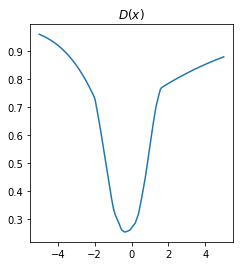

In [ ]:
############### plotting things
############### (1) plot the output of your trained discriminator 
r = D_xx.detach().numpy()
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.plot(xx, r)
plt.title(r'$D(x)$')

Text(0.5, 1.0, 'Estimated vs True')

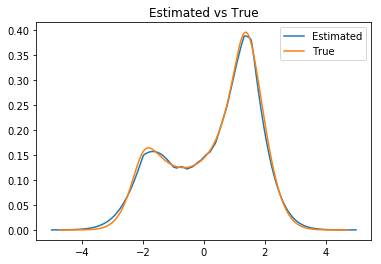

In [ ]:
############### (2) plot the estimated density contrasted with the true density
estimated_f1 = N(xx_tensor) * D_xx  / (1-D_xx)
estimate = estimated_f1.detach().numpy() 
#PLot
#plt.subplot(1,2,2)
plt.plot(xx, estimate)
plt.plot(f(torch.from_numpy(xx)).numpy(), d(torch.from_numpy(xx)).numpy()**(-1)*N(xx))
plt.legend(['Estimated','True'])
plt.title('Estimated vs True')